# Preprocessing of MIMIC-CXR dataset

This notebook illustrates how weak supervision can be applied on medical images and the corresponding reports. Since there are two sources of data (images and reports) we establish a double layer weak supervision. 

In this example the MIMIC-CXR dataset is used. There are two versions of this dataset: 

[MIMIC-CXR](https://physionet.org/content/mimic-cxr/2.0.0/) Database (Johnson, Pollard et al. 2019) is a large publicly available dataset of chest X-rays including radiology reports. It contains 377,110 images and 227,835 radiographic studies. A radiographic study consists of one report and one or multiple images. 

[MIMIC-CXR-JPG](https://physionet.org/content/mimic-cxr-jpg/2.0.0/) Database (Johnson, Lungren et al. 2019) is based on MIMIC-CXR. It additionally includes weak labels, which are derived from the radiology reports using the CheXpert labeler (Irvin, Rajpurkar et al. 2019) and the images are in JPG format instead of DICOM format. 

Neither versions of the MIMIC-CXR dataset have gold labels. Since both the CheXpert data and the MIMIC-CXR data contain chest X-Rays, the CheXpert labeler was used in the MIMIC-CXR-JPG Database to obtain weak labels. We will use a small subset of the MIMIC images and their weak labels in the data preprocessing to finetune our image encoder CNN (which was pretrained on ImageNet). Apart from that we do not touch any labels until evaluation.
To evaluate our results in the end, we apply the trained model (Knodle output) to the validation data of the CheXpert dataset, since they have gold labels. 

Below we provide little sketch of the pipeline implemented.
In the data preprocessing we build the three input matrices knodle requires:
 * The rules are generated from the [CheXpert Labeler phrases](https://github.com/stanfordmlgroup/chexpert-labeler/tree/master/phrases/mention). The phrases contain mentions (synonyms or related words) for each class, which we use to build our T matrix, so the "rule to class" matrix. 
 * The Z matrix, so the "rule matches" matrix is generated from the reports and the rules. 
 * The images are encoded with a CNN. We try two different approaches: 1) CNN with pretrained weights without finetuning and 2) CNN with pretrained weights and finetuning. For finetuning, we need the weak labels.
 

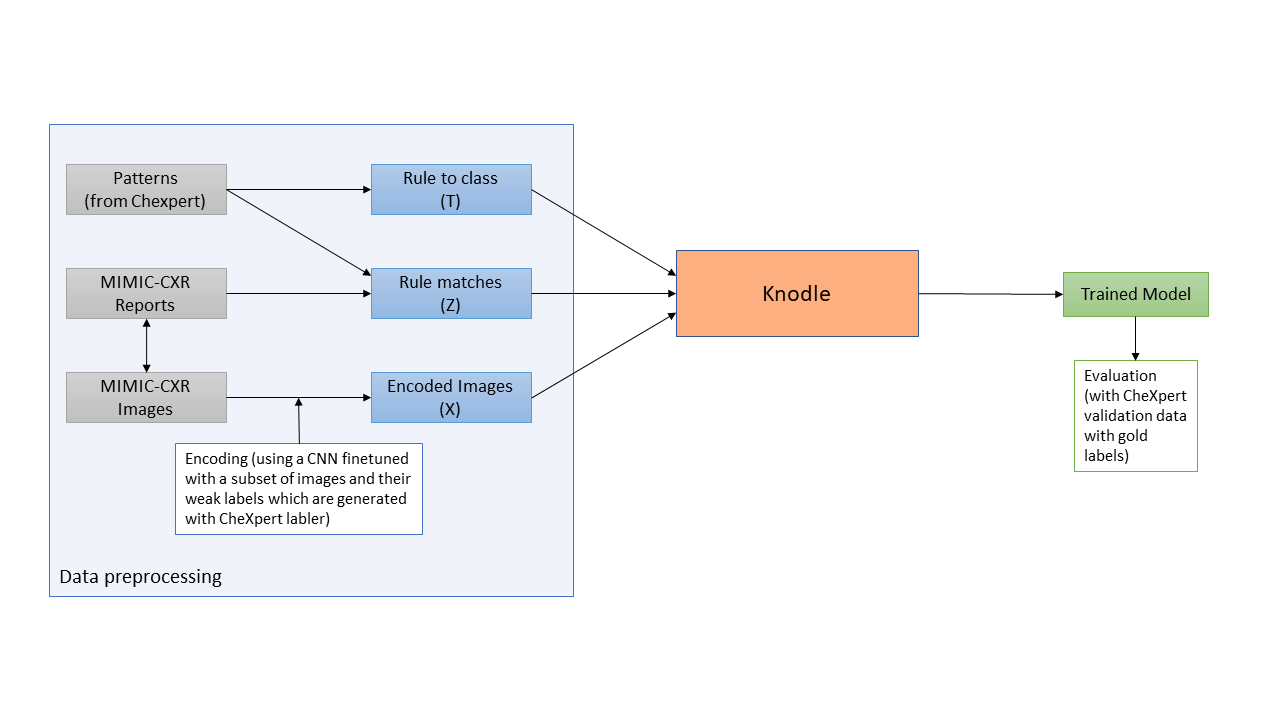

## Imports

First, let's make some basic imports. Make sure that all libraries listed in the requirements file are installed.

In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import random
import copy
import csv
import itertools

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from typing import Dict
from joblib import dump
from PIL import Image

In [ ]:
!pip install -r requirements.txt

## Getting all set up

To get access to the data, one needs to be a "credential user" in PhysioNet and sign the data use agreement. To be able to run this tutorial yourself, the following steps should be conducted:
1. To get a credentialed PhysioNet account, follow the following [instructions](https://physionet.org/about/citi-course/). 
2. Then sign the data use agreement for both, the MIMIC-CXR and the MIMIC-CXR-JPG database.
3. Check if `wget` is installed on your device, it will be used to download the data directly from PhysioNet.
4. Set your working directory to a prefered folder. The data will be downloaded into this folder. 
5. Check if you have enough memory space in the current directory (all images are 557.6 GB, when n = 10,000 it takes up 29GB)
6. Set n (number of studies, of which the images should be downloaded)
7. Set "download = True" if you run the script for the first time, and still need to download the data. Set "download = False" if you already run the script once and the data is already downloaded. 
8. If download = True, insert your PhysioNet username and password.

In [2]:
#os.chdir("")
# set n (number of studies) between 1 and 50375
n = 10000

In [3]:
download = False
# PhysioNet
if download:
    USERNAME = "your_username_here"
    PASSWORD = "your_pw_here"

### Specify output

The three output matrices for training will be stored as:
* T: "mapping_rules_labels_t.lib"
* Z: "rule_matches_z.lib"
* X: "train_X.lib" and "train_X_finetuned.lib"

The test data will be stored as:
* X test: "X_test.lib" and "X_test_finetuned.lib" 
* y test: "gold_labels_test.lib"

The finetuned resnet50 model will be stored as:
* finetuned model: "finetuned_model.lib"

In [4]:
Z = "rule_matches_z.lib"
T = "mapping_rules_labels_t.lib"
X = "train_X.lib"
X_FINETUNED = "train_X_finetuned.lib"
X_TEST = "X_test.lib"
X_TEST_FINETUNED = "X_test_finetuned.lib"
Y_TEST = "gold_labels_test.lib"

FINETUNED_MODEL = "finetuned_model.lib"

# Downloads

The following code will download some files we will need directly from PhysioNet:
* `"cxr-record-list.csv.gz"` (from mimic-cxr),
* `"cxr-study-list.csv.gz"` (from mimic-cxr),
* `"mimic-cxr-reports.zip"` (from mimic-cxr),
* `"mimic-cxr-2.0.0-chexpert.csv.gz"` (from mimic-cxr-jpg)

The first file contains the paths we need to download the actual images in the next stage. The second file contains the paths for the report TXT files. Those we will need to load the reports. The third download is the zip-folder of all reports. The last file contains the chexpert results, where we will extract our weak labels from.

In [5]:
if download:
    # downloads from mimic-cxr
    url = ["wget -N -c -np --user=", USERNAME, " --password=", PASSWORD, " https://physionet.org/files/mimic-cxr/2.0.0/"]

    command = "".join(url+["cxr-record-list.csv.gz"]) # paths to images
    os.system(command)
    command = "".join(url+["cxr-study-list.csv.gz"]) # paths to reports
    os.system(command)
    command = "".join(url+["mimic-cxr-reports.zip"]) # folder of all reports
    os.system(command)

    # downloads from mimic-cxr-jpg
    url = ["wget -N -c -np --user=", USERNAME, " --password=", PASSWORD, " https://physionet.org/files/mimic-cxr-jpg/2.0.0/"]
    command = "".join(url+["mimic-cxr-2.0.0-chexpert.csv.gz"]) # chexpert output for mimic dataset
    os.system(command)

Now **unzip** all files and the folder of reports with 7zip.

### Downloading MIMIC-CXR-JPG images

Next, we are going to download the X-ray images. Since the full dataset is  557.6GB large, we want to allow to download only a subset of images. Additionally we define conditions on which studies we want to keep:
* we only include studies where there are two images, since a chest x-ray analysis usually consists of one frontal and one lateral image. 
* we only want to include one study per person, since we want independent images.

In [6]:
record_list_all = pd.read_csv("cxr-record-list.csv")
study_list = pd.read_csv("cxr-study-list.csv").to_numpy()

# restrict records
# only want to include studies where there are two images
# only want to include one per person
two_records_per_study = record_list_all.groupby("study_id").count() == 2
two_records_per_study = two_records_per_study.rename(columns={"subject_id":"two_rec"})
record_list = pd.merge(record_list_all, two_records_per_study["two_rec"], 
                              how = "left", on= ["study_id"])
record_list_reduced = record_list[record_list["two_rec"]]
record_list_reduced = record_list_reduced.groupby("subject_id").head(2)
record_list_pd = record_list_reduced.drop(columns = ["two_rec"])
record_list = record_list_pd.to_numpy()

# draw a random subset 
random.seed(10)
study_indices = random.sample(range(int(len(record_list)/2)), n)
record_indices = [element * 2 for element in study_indices]+[element * 2+1 for element in study_indices]
record_indices.sort() 

Now we will download the images of n studies.

In [7]:
if download:            
    for i in tqdm(record_indices):
        path = record_list[i,3]
        url = ["wget -N -c -np --user=", USERNAME, " --password=", PASSWORD, 
               " https://physionet.org/files/mimic-cxr-jpg/2.0.0/",
               path, " -P ", path.replace("/"+record_list[i,2]+".dcm", "")]
        command = "".join(url).replace(".dcm", ".jpg")
        os.system(command)

We are done with downloading, now let's process the data.

## Processing the reports

The reports are all stored in seperate TXT files. Each report has the following structure:

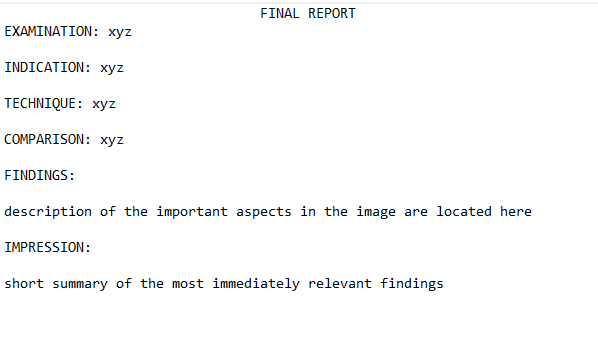


We process the reports so that we get one file for all reports in the CSV format where each report is saved in a separate row. We extract the "Findings" and "Impressions" sections from each report and save it to one CSV. 

In [8]:
 if download:
    with open("mimic_cxr_text.csv", "w", newline="", encoding="utf-8") as f:
        for i in tqdm(range(len(study_list))):
            with open("".join(["mimic-cxr-reports/", study_list[i,2]])) as f_path:
                text = "".join(f_path.readlines())
            text = text.replace("\n", "")
            text = text.replace(",", "")
            start = text.find("FINDINGS:")
            end = text.find("IMPRESSION:")
            findings = text[start:end]
            impressions = text[end:len(text)]
            row = [study_list[i,0],study_list[i,1], findings, impressions]
            csvwriter = csv.writer(f)
            csvwriter.writerow(row)

In [9]:
# open report csv
reports = pd.read_csv("mimic_cxr_text.csv", 
                      names = ["subject_id","study_id", "findings", "impressions"], 
                      na_values=".")

Let's get an overview of the reports. We calculate the average length of the finding and impression section. 

In [10]:
print("average length findings section:", np.mean(reports["findings"].str.len()))

print("average length impression section:", np.mean(reports["impressions"].str.len()))

average length findings section: 348.6685509250907
average length impression section: 193.16239243554105


The section "Findings" contains a description of the important aspects in the image, while the section "Impression" gives a short summary of the most immediately relevant findings. In the current preprocessing, we use the "Impression" section or, if impressions are not available, the "Finding" section instead. This is the approach Irvin, Rajpurkar et al. used in the MIMIC-CXR-JPG paper when extracting weak labels from the reports. The reports that do not contain any impression or findings sections (about 5% of all reports) are ignored in this analysis.

In [11]:
print("proportion of NAs in findings and impressions:\n", pd.isna(reports[['findings', 'impressions']]).sum()/len(reports))

proportion of NAs in findings and impressions:
 findings       0.343117
impressions    0.174214
dtype: float64


In [12]:
# if impression is missing insert finding
reports.impressions.fillna(reports.findings, inplace=True)
# if neither are there, we do not analyse this study -> drop
del reports["findings"]
reports_processed = reports.dropna()

### Merge reports

Now we merge the reports to our record list such that each image gets a report assigned if a report is available. 
If a report refers to multiple images (e.g. one frontal and one lateral X-ray), the report is merged to all refered images.

In [13]:
# merge reports to record_list
record_report_list = pd.merge(record_list_pd, reports_processed, 
                              how = "left", on= ["study_id","subject_id"])

In [15]:
# only first n rows, drop nas
input_list_pd = record_report_list.iloc[record_indices,:].dropna()
input_list = input_list_pd.to_numpy()
# save new n
n = int(len(input_list)/2)
print(n)

9731


We will extract a subset of the input list according to the record indices sampled before. Then the the rows including missing values are dropped. Instead of n=10000 we now continue working with n=9731 studies. 

## Creating rules from Chexpert-labeler

We are using the ["mentions" from Chexpert-labeler](https://github.com/stanfordmlgroup/chexpert-labeler/tree/master/phrases/mention) for building our rules. In the 'mentions' folder there are TXT files with keywords for each class. To use these keywords as our rules, we need to download the TXT files from GitHub. The file names are the labels we defined above, where all letters are lowercase and instead of whitespaces, there are underscores. So first we do some transformations to get a list of our classes. 

In [16]:
labels_chexpert = pd.read_csv("mimic-cxr-2.0.0-chexpert.csv")
labels = {id: cat for (cat, id) in enumerate(labels_chexpert.columns[2:16])}
# lower case & replace whitespace with _
classes = [string.lower().replace(" ", "_") for string in labels]
num_classes = len(classes)
labels2ids = {classes[i]:i for i in range(num_classes)}

Now we create a new folder in our directory and store the TXT files there. 

In [17]:
if download:
    # create folder chexpert_rules
    os.makedirs("".join([os.getcwd(),"/chexpert_rules"]))
    # store files in folder
    for i in range(len(classes)):
        os.system("".join(["curl https://raw.githubusercontent.com/stanfordmlgroup/chexpert-labeler/master/phrases/mention/", 
                           classes[i], ".txt ", "-o chexpert_rules/", classes[i], ".txt"]))

### T Matrix
The T matrix contains information about which rule corresponds to which label. In the following snippets, we build this matrix. 

In [18]:
# read txt in
lines = {}
for i in range(len(classes)):
    with open("".join(["chexpert_rules/", classes[i], ".txt"])) as f:
        lines[classes[i]] = [each_string.replace("\n", "") for each_string in f.readlines()]
          
mentions = pd.DataFrame({"label": label, "rule": rule} for (label, rule) in lines.items())
mentions.head()

,label,rule
0,atelectasis,"[atelecta, collapse]"
1,cardiomegaly,"[cardiomegaly, the heart, heart size, cardiac ..."
2,consolidation,[consolidat]
3,edema,"[edema, heart failure, chf, vascular congestio..."
4,enlarged_cardiomediastinum,"[_mediastinum, cardiomediastinum, contour, med..."


We now build a dataframe 'rules', which gathers information about rules and labels. Its columns are: rule, rule_id, label and label_id

In [19]:
# building the dataframe "rules"
rules = pd.DataFrame([i for i in itertools.chain.from_iterable(mentions["rule"])], columns = ["rule"])
rules["rule_id"] = range(len(rules))
rules["label"] = np.concatenate([
    np.repeat(mentions["label"][i], len(mentions["rule"][i])) for i in range(num_classes)])
rules["label_id"] = [labels2ids[rules["label"][i]] for i in range(len(rules))]
rules.head()

,rule,rule_id,label,label_id
0,atelecta,0,atelectasis,0
1,collapse,1,atelectasis,0
2,cardiomegaly,2,cardiomegaly,1
3,the heart,3,cardiomegaly,1
4,heart size,4,cardiomegaly,1


In [21]:
rule2rule_id = dict(zip(rules["rule"], rules["rule_id"]))
rule2label = dict(zip(rules["rule_id"], rules["label_id"]))

def get_mapping_rules_labels_t(rule2label: Dict, num_classes: int) -> np.ndarray:
    """ Function calculates t matrix (rules x labels) using the known correspondence of relations to decision rules """
    mapping_rules_labels_t = np.zeros([len(rule2label), num_classes])
    for rule, labels in rule2label.items():
        mapping_rules_labels_t[rule, labels] = 1
    return mapping_rules_labels_t

mapping_rules_labels_t = get_mapping_rules_labels_t(rule2label, len(labels2ids))
print("T matrix:", mapping_rules_labels_t[0:5,:])
print("shape:", mapping_rules_labels_t.shape)

dump(mapping_rules_labels_t, T)

T matrix: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shape: (148, 14)


['mapping_rules_labels_t.lib']

We derive our T matrix with 148 rules for 14 classes. 

Now we want to check if there are any rules, which assigns 1 to the same class. Indeed, there is one case: rule "defib" builds a rule for two different classes. In our T matrix, "defib" occures in two rows. 

In [22]:
len(np.unique(rules["rule"])) == len(rules["rule"])
rules_size = rules.groupby("rule").size() 
rules_size[np.where(rules_size > 1)[0]]
# rule defib appears for two different classes

rule
defib    2
dtype: int64

### Z Matrix
The Z matrix contains the information about the rules matched to the reports. Its shape is #instances x #rules. 

In [23]:
def get_rule_matches_z (data: np.ndarray, num_rules: int) -> np.ndarray:
    """
    Function calculates the z matrix (samples x rules)
    data: np.array (reports)
    output: sparse z matrix
    """
    rule_matches_z = np.zeros([len(data), num_rules])
    for ind in range(len(data)):
        for rule, rule_id in rule2rule_id.items():
            if rule in (data[ind]):
                rule_matches_z[ind, rule_id] = 1
    return rule_matches_z

# insert every second row of input_list (one for each study)
rule_matches_z = get_rule_matches_z(input_list[range(0,n*2,2),4], (len(rule2rule_id)+1))

In [24]:
# how many studies without matches
print("proportion of studies without any matches:\n", 
      sum(np.sum(rule_matches_z, axis = 1)==0)/len(rule_matches_z))

proportion of studies without any matches:
 0.43243243243243246


43% of our reports do not match any of the rules. We will keep this in mind when we train a model with knodle.

In [25]:
dump(rule_matches_z, Z)

['rule_matches_z.lib']

# Image encoding 
For the image encoding we try two different approaches:
1. extract features using a model pretrained on ImageNet (no finetuning)
2. finetune a model pretrained on ImageNet and then extract features (finetuning with weak chexpert labels)

## First approach: Extracting features using a pretrained model (no finetuning)

For the implementation we use PyTorch and the [ResNet50](https://arxiv.org/abs/1512.03385) CNN which was pretrained on ImageNet from `torchvision` library. 
The following class loads the data and transforms it in the way it is required for ResNet50. It is written in a way so that it is compatible with `torch.utils.data.DataLoader`. 

In [26]:
class mimicDataset(Dataset):
    
    def __init__(self, path, load_labels = False):
        "initialization"
        self.path = path
        self.load_labels = load_labels
        
    def __len__(self):
        "total number of samples"
        return len(self.path)
    
    def __getitem__(self, index):
        "one sample of data"
        # Select sample
        image = Image.open(self.path[index,3].replace(".dcm", ".jpg")).convert("RGB")
        X = self.transform(image)
        if self.load_labels: # for the second approach with finetuning
            label = self.path[index,5]      
            return X, torch.tensor(label)
        else:
            return X # for the first approach without labels
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

We load the ResNet50 model and remove the last layer, so the output is then extracted from the second last layer with dimension 1x2048. These are our features. 

In [32]:
model = models.resnet50(pretrained=True)
modules = list(model.children())[:-1]
model=torch.nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False
    
model.eval()
# apply modified resnet50 to data    
img_embedding = np.zeros([n*2,2048])
dataloaders = DataLoader(mimicDataset(input_list), batch_size=1,num_workers=0)
for i, data in enumerate(tqdm(dataloaders)):
    features_var = model(data) # same model as used with training data
    features = features_var.data 
    img_embedding[i,:] = features.reshape(1,2048).numpy()

Now the embeddings of the two images of a study are concatenated. 

In [33]:
# concatenate both image embeddings of a study to one embedding
train_X = np.zeros([n, 2048*2])
for i in range(n):
    train_X[i,:] = np.concatenate((img_embedding[i,:], img_embedding[i+1,:]))

Finally, we save the study feature matrix.

In [34]:
dump(train_X, X)

['train_X.lib']

## Second approach: Finetuning a pretrained CNN (with weak CheXpert labels)

In the second approach of image encoding, we use the concept of transfer learning. 
Therefore, we take a CNN pretrained on ImageNet and continue training the model with our data. We do this because the images from ImageNet are very different from our medical images, and we hope to achive better encodings with a finetuned model. 
For the implementation we again use PyTorch library and the pretrained ResNet50 from `torchvision` library. 

For finetuning, we need labels, therefore we extract labels from the chexpert output in the following subsection.  

### Add labels
In this section, we add the weak labels to the `input_list` and call it `input_list_labels`. It contains all relevant information about the images (id, path, label) we need for finetuning. Note that we only use the labels for finetuning the image encoding CNN. 


To get our labels we need to extract them from the CheXpert output.

The CheXpert labeler detects the presence of 14 diagnoses in radiology reports. 
"mimic-cxr-2.0.0-chexpert.csv" contains one column for each of the 14 diagnoses and one row for each study. Each study and each diagnosis has assigned one of the four values: 1.0,-1.0, 0.0 or missing. They have the following interpretation:

* 1.0 The label was positively mentioned in the associated study, and is present in one or more of the corresponding images
* 0.0 The label was negatively mentioned in the associated study, and therefore should not be present in any of the corresponding images
* -1.0 The label was either: (1) mentioned with uncertainty in the report, and therefore may or may not be present to some degree in the corresponding image, or (2) mentioned with ambiguous language in the report and it is unclear if the pathology exists or not
* Missing (empty element) - No mention of the label was made in the report

(Johnson, Lungren et al. 2019)

We are primarily interested in the 1.0s.
One study can have multiple labels positively mentioned, like it is the case in row 7 below.

In [35]:
labels = {id: cat for (cat, id) in enumerate(labels_chexpert.columns[2:16])}

In [36]:
labels_chexpert.iloc[:,2:].head(8) # note that we removed the ids in the output due to data privacy

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,1.0,NaN,1.0,NaN,NaN


To get one label for each study, we do the following:
* If there is exactly one label positively mentioned, this label will be assigned to the study. 
* If there are multiple labels positively mentioned, one label will be chosen randomly. 
* When there is no 1.0 assigned to the study, the label will be set to 'No Finding'.

In [37]:
# initialise labels with 0
labels_chexpert["label"] = 0
labels_list = labels_chexpert.columns.to_numpy()
# iterate through labels: 
# three cases: only one, non, or multiple diagnoses
for i in tqdm(range(len(labels_chexpert))):
    # which labels are 1? 
    label_is1 = labels_chexpert.iloc[i,:] == 1.0
    if (sum(label_is1)==1):
       labels_chexpert.iloc[i,16] = labels_list[label_is1]
    elif sum(label_is1) > 1:
        labels_chexpert.iloc[i,16] = random.choice(labels_list[label_is1])
    else: 
        labels_chexpert.iloc[i,16] = "No Finding"

100%|██████████| 227827/227827 [11:45<00:00, 322.84it/s]


In [38]:
labels_chexpert["label"].head(8)

0          No Finding
1          No Finding
2          No Finding
3          No Finding
4       Consolidation
5          No Finding
6          No Finding
7    Pleural Effusion
Name: label, dtype: object

### Merge labels

Next, the records, reports and labels are merged to one file. Note that sometimes one report refers to multiple X-rays (e.g. one frontal and one lateral X-ray) and since the labels are derived from the reports, one label might refer to multiple images.

In [39]:
# merge labels with records and reports
input_list_labels_pd = pd.merge(input_list_pd, 
                                    labels_chexpert.iloc[:,[0,1,16]], 
                                    how = "left", 
                                    on = ["study_id","subject_id"])

In [40]:
print("classes proportions:", 
      input_list_labels_pd.groupby("label").size()/len(input_list_labels_pd))

classes proportions: label
Atelectasis                   0.056418
Cardiomegaly                  0.060631
Consolidation                 0.010276
Edema                         0.021272
Enlarged Cardiomediastinum    0.008221
Fracture                      0.017162
Lung Lesion                   0.014079
Lung Opacity                  0.082211
No Finding                    0.598294
Pleural Effusion              0.046758
Pleural Other                 0.003186
Pneumonia                     0.033398
Pneumothorax                  0.009043
Support Devices               0.039050
dtype: float64


There are 14 classes, where about 60% of the studies are assigned to the class 'No finding'. We should keep in mind that we are dealing with an unbalanced dataset.

Lastly, we replace the class names with their indices and convert the pandas dataframe to a numpy array.

In [41]:
# Changing names to indices
for i in tqdm(range(len(input_list_labels_pd))):
 input_list_labels_pd.iloc[i,5] = labels.get(input_list_labels_pd.iloc[i,5])

100%|██████████| 19462/19462 [00:05<00:00, 3426.28it/s]


In [42]:
# convert to numpy
input_list_labels = input_list_labels_pd.to_numpy()

['input_list_labels.lib']

### Finetuning

First, we set a number of images, which should be used for finetuning. If the number of images downloaded is less than 800, all images are used, otherwise we will use 800.

In [51]:
# m ... number of images used for finetuning
m = min(800,n*2)

Then we split the finetuning data randomly into 80% training and 20% validation data.

In [52]:
# 80% training and 20% validation
n_train = round(m*0.8)
indices_train = random.sample(range(m),n_train)

input_train = input_list_labels[:m,:][indices_train,:]
input_validate = np.delete((input_list_labels[:m,:]),indices_train, axis = 0)

Since the dataset is unbalanced, we use a weighted sampler 

In [73]:
class_counts = np.zeros(num_classes)
for i in range(num_classes): 
    class_counts[i] = sum(input_train[:,5]==i)
print(class_counts)

[ 41.  37.  17.   6.   5.  24.   5.  44. 380.  28.   5.  19.   2.  27.]


Here we make sure that no class_count is 0, before we divide through class_counts to calculate the weights.

In [54]:
weight = 1/class_counts
sample_weights = np.array([weight[t] for t in input_train[:,5]])
sample_weights = torch.from_numpy(sample_weights)
sample_weights = sample_weights.double()
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, 
                                                 num_samples=len(sample_weights))

In [55]:
dataset = {"train" : mimicDataset(input_train, load_labels = True),
           "val": mimicDataset(input_validate, load_labels = True)}

dataloaders = {"train": DataLoader(dataset["train"] , batch_size=4, num_workers=0, sampler = sampler),
               "val": DataLoader(dataset["val"] , batch_size=4, num_workers=0 )}


dataset_sizes = {x: len(dataset[x]) for x in ["train", "val"]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The following function, which trains the model is taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [56]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print("Best val Acc: {:4f}".format(best_acc), )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


Now we initialize the model:
The size of the output layer equals the number of classes (14 classes in our case). We choose the CrossEntropy as a loss function, the Adam optimizer and an adaptive learning rate. 
The model is finetuned using only two epochs, since more epochs would overfit the model too much.

In [57]:
model = models.resnet50(pretrained=True)
model.train()
num_ftrs = model.fc.in_features
# set output size to 14 (number of classes)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 1.7456 Acc: 0.4813
val Loss: 1.8186 Acc: 0.4000

Epoch 1/2
----------
train Loss: 0.9000 Acc: 0.7750
val Loss: 2.0889 Acc: 0.3063

Epoch 2/2
----------
train Loss: 0.6045 Acc: 0.8328
val Loss: 1.8611 Acc: 0.4313

Best val Acc: 0.431250


In [59]:
dump(model, FINETUNED_MODEL)

['finetuned_model.lib']

Now, that we have trained our model, we will extract the embeddings. 

In the next step, the last layer is removed from the model, so the output is then the second last layer with dimension 1x2048.
Then we let all images run through the model. 

In [60]:
modules = list(model.children())[:-1]
model=torch.nn.Sequential(*modules)
model.eval()
for p in model.parameters():
    p.requires_grad = False
    
# apply modified resnet50 to data
img_embedding_finetuned = np.zeros([n*2,2048])
dataloaders = DataLoader(mimicDataset(input_list_labels, load_labels = True), batch_size=1,num_workers=0)
for i, data in enumerate(tqdm(dataloaders)):
    data_train, weak_labels = data
    features_var = model(data_train) # same model as used with training data
    features = features_var.data 
    img_embedding_finetuned[i,:] = features.reshape(1,2048).numpy()

100%|██████████| 19462/19462 [1:10:22<00:00,  4.61it/s]


Then we concatenate the two embeddings of one study (each of dimension 1x2048) to one feature vector (of dimension 1x4096). 

In [61]:
# concatenate both image embeddings of a study to one embedding
train_X_finetuned = np.zeros([n, 2048*2])
for i in range(n):
    train_X_finetuned[i,:] = np.concatenate((img_embedding_finetuned[i,:], img_embedding_finetuned[i+1,:]))

Finally, we save the feature array generated with the finetuned CNN. 

In [62]:
dump(train_X_finetuned, X_FINETUNED)

['train_X_finetuned.lib']

We have now finished the data preprocessing for the training data. All matrices (X,T,Z) are saved and ready for knodle!

# Test data

As test data we use the CheXpert validation data, which contains gold labels (Irvin, Rajpurkar et al. 2019). Here we process the test data in the same way we processed the train data.

The data can be found on [this homepage](https://stanfordmlgroup.github.io/competitions/chexpert/). After the use agreement is signed, you receive an e-mail with two links. One for the dataset at high-resolution and one at downsampled resolution. Here we use the latter. 

**Unzip** the folder in your current directory, and you are ready to run the following code

## Test data preparation

First we load the data.

In [63]:
test_set_pd = pd.read_csv("CheXpert-v1.0-small/CheXpert-v1.0-small/valid.csv")
# add column with study_id
test_set_pd = test_set_pd.assign(study_id = lambda x: x['Path'].map(lambda string: "".join(string.split("/")[2:4])))
test_set = test_set_pd.to_numpy()

Then we extract the order of the labels and save them in an array.

In [64]:
# order of labels
labels_test_list = test_set_pd.columns[5:19].to_numpy()

`chexpertDataset` is a class, which reads the images and the labels in, similarly like we did it with the training data.

In [65]:
class chexpertDataset(Dataset):
    
    def __init__(self, path):
        "initialization"
        self.path = path
        
    def __len__(self):
        "total number of samples"
        return len(self.path)
    
    def __getitem__(self, index):
        "one sample of data"
        # Select sample
        image = Image.open("".join("CheXpert-v1.0-small/" + self.path[index,0])).convert("RGB")
        X = self.transform(image)
        
        return X
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

After loading the images and the gold labels, the same model for image encoding as used for the training data is applied to the test data.

In [67]:
# apply model from before
model.eval()
n_test = len(test_set)
img_embedding_test = np.zeros([n_test,2048])
dataloaders = DataLoader(chexpertDataset(test_set), batch_size=1,num_workers=0)
for i, data in enumerate(tqdm(dataloaders)):
    features_var = model(data) # same model as used with training data
    features = features_var.data 
    img_embedding_test[i,:] = features.reshape(1,2048).numpy()

100%|██████████| 234/234 [00:25<00:00,  9.12it/s]


CheXpert validation data does not always have two images per study, so we use a padding if there is only one image per study available. 

In [68]:
# concatenate image embeddings of a study to one embedding
test_X = np.zeros([n_test, 2048*2])
j = []
for i in range(n_test-1):
    if  test_set[i,19] == test_set[i+1,19]: # two images of same study
        test_X[i,:] = np.concatenate((img_embedding_test[i,:], img_embedding_test[i+1,:]))
        j.append(i+1) # i+1 embedding is are already incuded in i-th embedding, keep indices to remove later
        
    elif i == n_test-2: # last two entries
        test_X[i,:] = np.concatenate((img_embedding_test[i,:], np.zeros(2048)))
        test_X[i+1,:] = np.concatenate((img_embedding_test[i+1,:], np.zeros(2048)))
        
    else:
        test_X[i,:] = np.concatenate((img_embedding_test[i,:], np.zeros(2048)))
test_X = np.delete(test_X,j,0) # remove j rows

The corresponding gold labels we save in lists in a list. Multiple labels are possible. 

In [70]:
# extracting gold labels
ind = np.delete(range(n_test),j,0)
gold_labels_test = []
for i in ind:
    label_is1 = test_set[i,5:19] == 1.0
    if (sum(label_is1) != 0):
        gold_labels_test.append([labels[x] for x in labels_test_list[np.where(label_is1)[0]]])
    else: 
        gold_labels_test.append([8]) # no finding
        
print(gold_labels_test[:5])

[[4, 1, 7], [13], [4, 7, 3], [8], [4, 7, 0, 9]]


Finally we save the test data. 

In [72]:
dump(test_X, X_TEST_FINETUNED)
dump(gold_labels_test, Y_TEST)

['gold_labels_test.lib']

## Finish
Both, the training and the testing data are now preprocessed. 

We upload some files which we created here to [MiniO](https://knodle.dm.univie.ac.at/minio/knodle/datasets/mimic_cxr/). Note that due to privacy issues we can not provide the raw data.

#### Processed Data:
* `rule_matches_z.lib`
*  `mapping_rules_labels_t.lib`

#### Finetuned CNN for image encoing:
* `finetuned_model.lib`


# References

Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2019). MIMIC-CXR Database (version 2.0.0). PhysioNet. https://doi.org/10.13026/C2JT1Q.

Johnson, A., Lungren, M., Peng, Y., Lu, Z., Mark, R., Berkowitz, S., & Horng, S. (2019). MIMIC-CXR-JPG - chest radiographs with structured labels (version 2.0.0). PhysioNet. https://doi.org/10.13026/8360-t248.

Irvin J., Rajpurkar P., Ko M., Yu Y., Ciurea-Ilcus S., Chute C. et al. (2019). CheXpert: A large chest radiograph dataset with uncertainty labels and expert comparison. https://arxiv.org/abs/1901.07031